In [1]:
# !pip install torch torchvision transformers

In [2]:
# !pip install qdrant_client pyMuPDF tools frontend git+https://github.com/openai/CLIP.git easyocr natsort

In [3]:
# !pip install layoutparser && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
# !pip uninstall -y Pillow
# !pip install Pillow==9.5.0
# !pip install pymupdf==1.22.2

In [4]:
# import layoutparser as lp
# model = lp.models.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
#                                  extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                  label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd
import torch
import os
import fitz

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
pdf_file = "./../Sample1/ljad096.pdf"
output_directory = './ouput_images/'
# Split the base name and extension
output_directory_path, _ = os.path.splitext(pdf_file)
output_directory_path = os.path.join(output_directory, output_directory_path.split("/")[-1])

print(output_directory_path)

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page and convert to an image
for page_number in range(pdf_document.page_count):
    # Get the page
    page = pdf_document[page_number]

    # Convert the page to an image
    pix = page.get_pixmap()

    # Create a Pillow Image object from the pixmap
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Save the image
    image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# Close the PDF file
pdf_document.close()

./ouput_images/ljad096


In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir(f"./{output_directory_path}/"):
    image_paths.append(str(os.path.join(f"./{output_directory_path}/", img_path)))

image_paths

['././ouput_images/ljad096/page_2.png',
 '././ouput_images/ljad096/page_3.png',
 '././ouput_images/ljad096/page_1.png',
 '././ouput_images/ljad096/page_4.png',
 '././ouput_images/ljad096/page_5.png',
 '././ouput_images/ljad096/page_7.png',
 '././ouput_images/ljad096/page_6.png',
 '././ouput_images/ljad096/page_10.png',
 '././ouput_images/ljad096/page_8.png',
 '././ouput_images/ljad096/page_9.png']

In [8]:
from natsort import natsorted
image_paths = natsorted(image_paths)
image_paths

['././ouput_images/ljad096/page_1.png',
 '././ouput_images/ljad096/page_2.png',
 '././ouput_images/ljad096/page_3.png',
 '././ouput_images/ljad096/page_4.png',
 '././ouput_images/ljad096/page_5.png',
 '././ouput_images/ljad096/page_6.png',
 '././ouput_images/ljad096/page_7.png',
 '././ouput_images/ljad096/page_8.png',
 '././ouput_images/ljad096/page_9.png',
 '././ouput_images/ljad096/page_10.png']

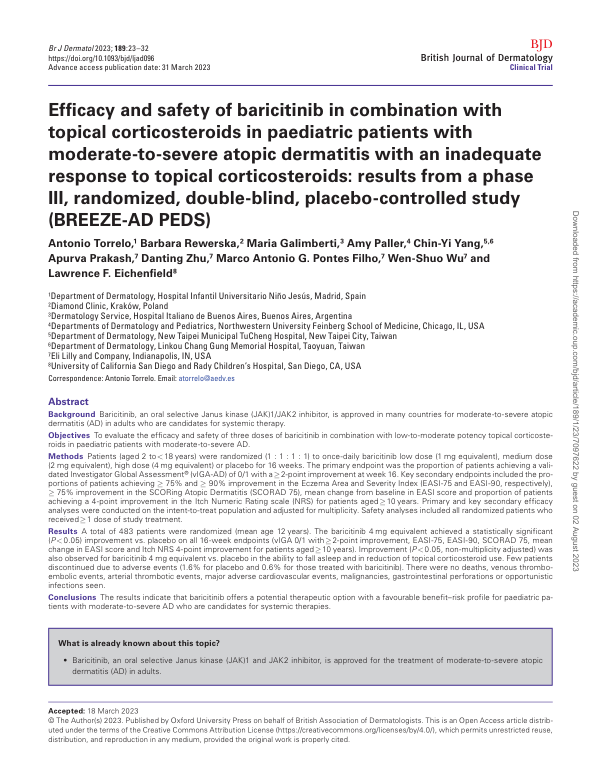

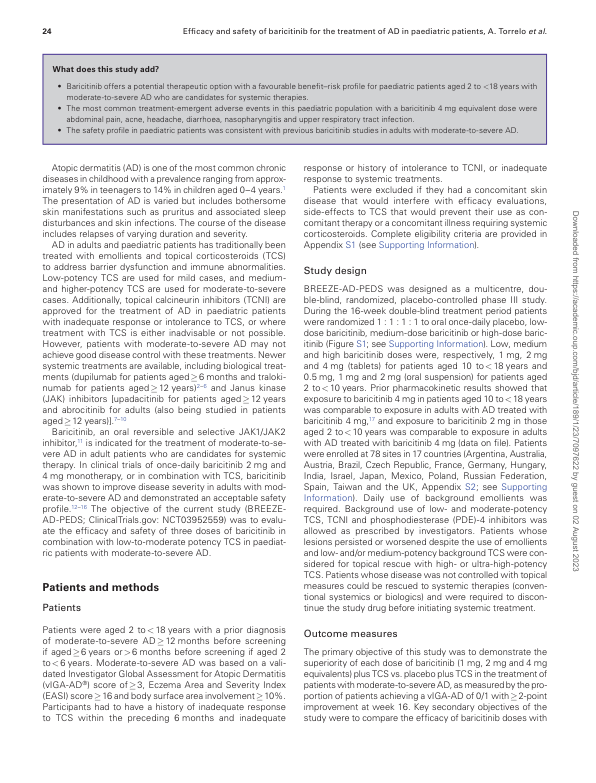

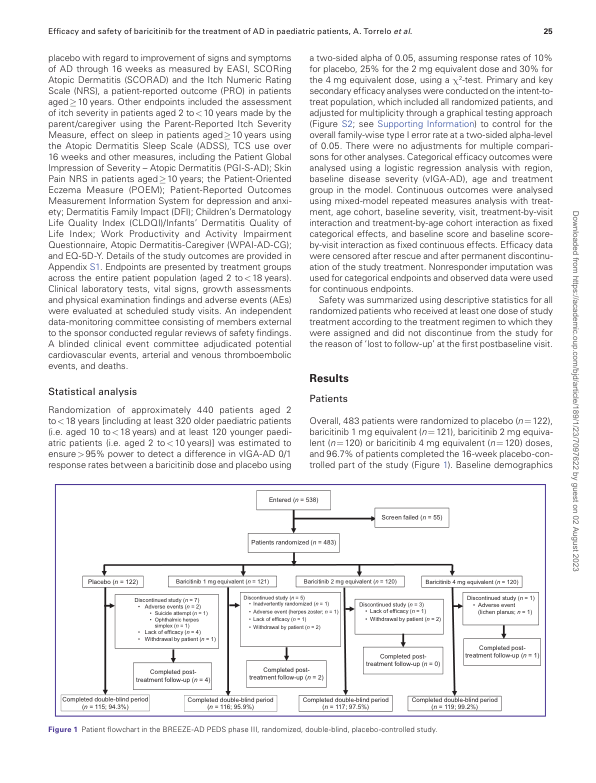

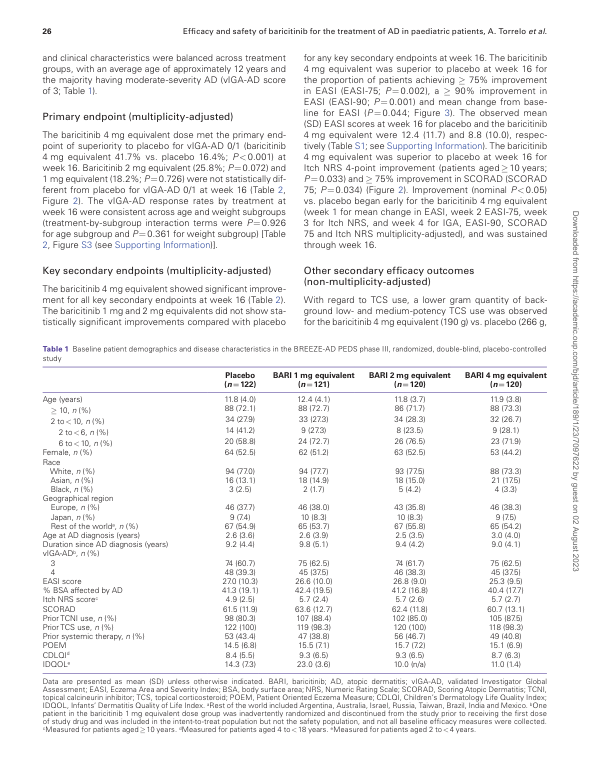

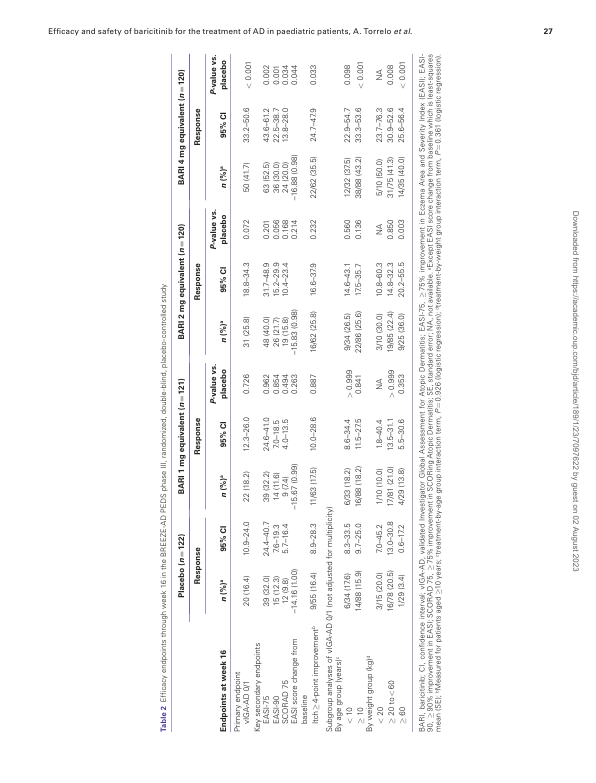

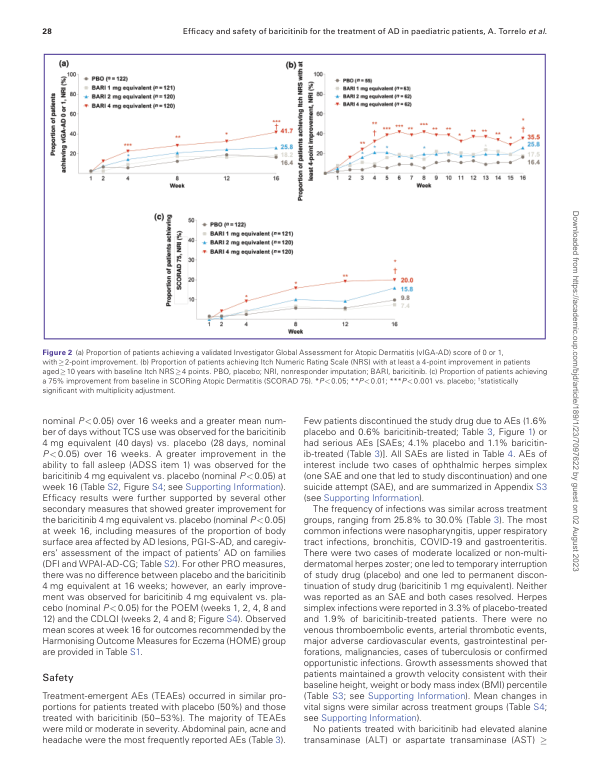

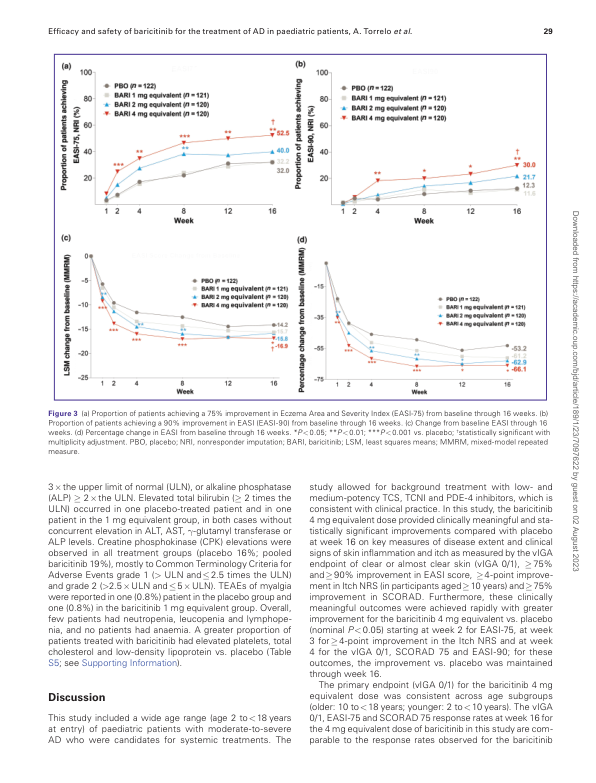

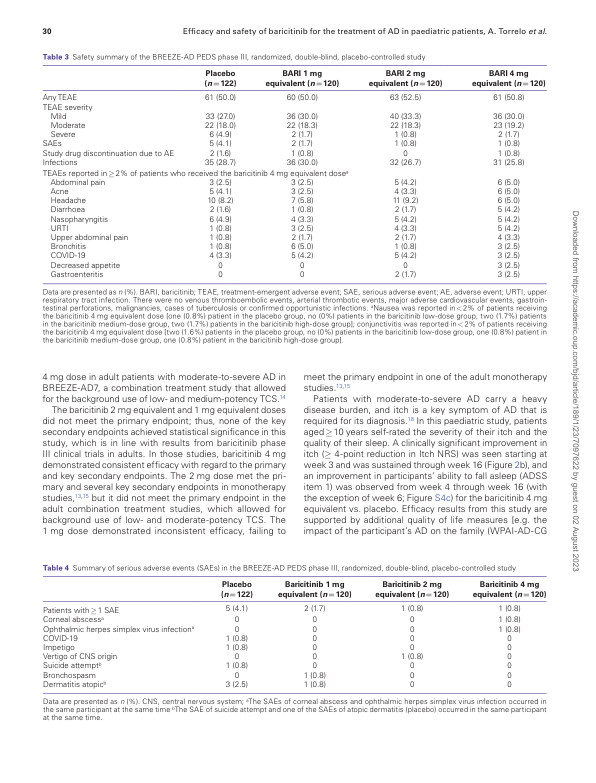

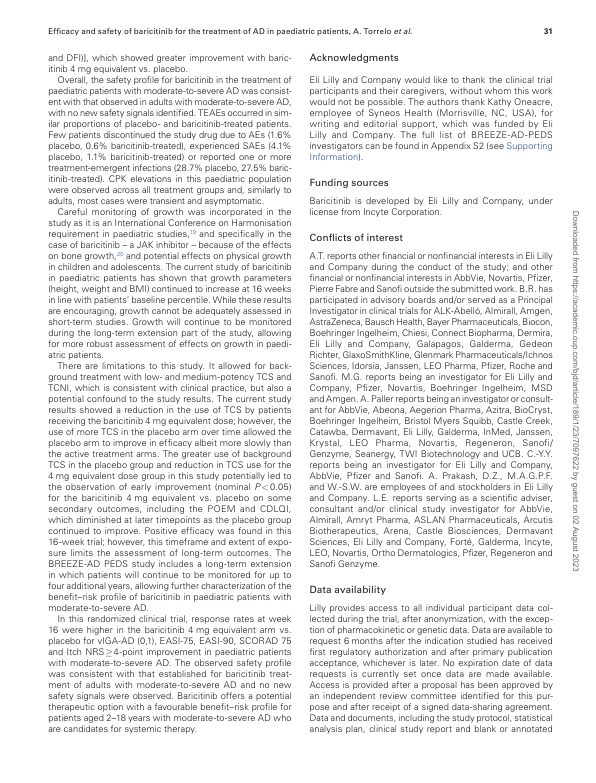

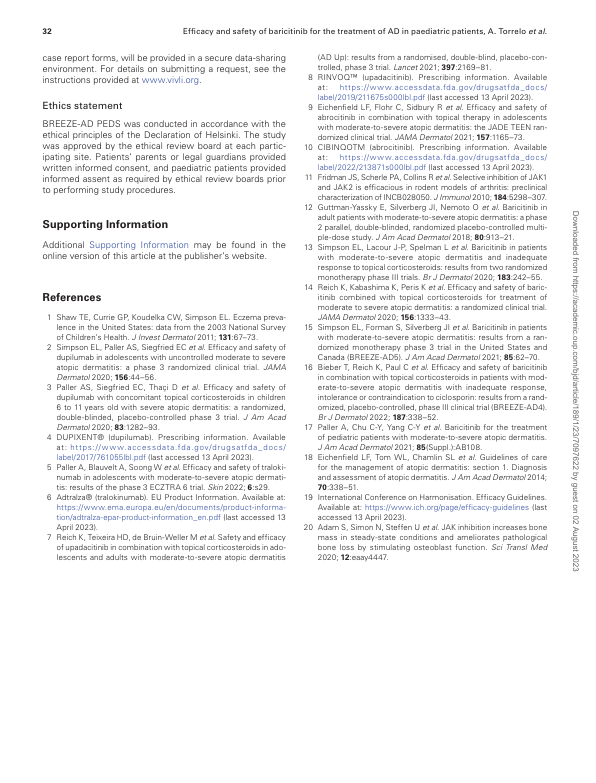

In [9]:
from IPython.display import Image, display

for imageName in image_paths:
    display(Image(filename=imageName))

In [10]:
from torchvision import transforms
from transformers import AutoModelForObjectDetection

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# load table detection model
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to(device)


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor(
        [width, height, width, height], dtype=torch.float32
    )
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects


def detect_and_crop_save_table(
    imageName, cropped_table_directory="./table_images/"
):
    import PIL.Image as Image
    
    image = Image.open(imageName)
    filename = imageName.split("/")[-1].split(".")[0]
    print(f"processing {filename}")

    # prepare image for the model
    pixel_values = detection_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values)

    # postprocess to get detected tables
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        # crop detected table out of image
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(f"./{cropped_table_directory}/{filename}_{idx}.png")


In [11]:
cropped_table_directory = f"./{output_directory_path}_cropped_table_images"
if not os.path.exists(cropped_table_directory):
    os.makedirs(cropped_table_directory)
    
for imageName in image_paths:
    detect_and_crop_save_table(imageName, cropped_table_directory)

processing page_1
number of tables detected 1
processing page_2
number of tables detected 0
processing page_3
number of tables detected 0
processing page_4
number of tables detected 1
processing page_5
number of tables detected 1
processing page_6
number of tables detected 0
processing page_7
number of tables detected 0
processing page_8
number of tables detected 2
processing page_9
number of tables detected 2
processing page_10
number of tables detected 2


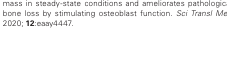

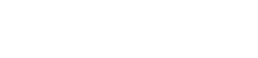

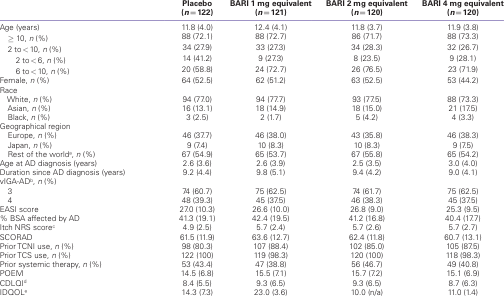

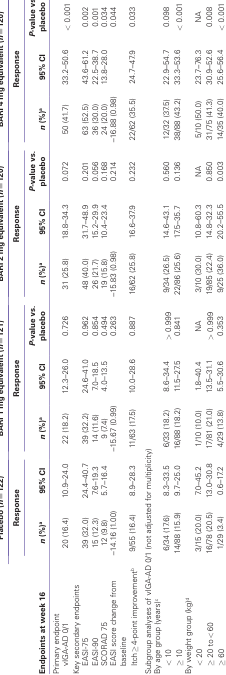

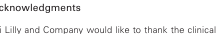

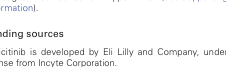

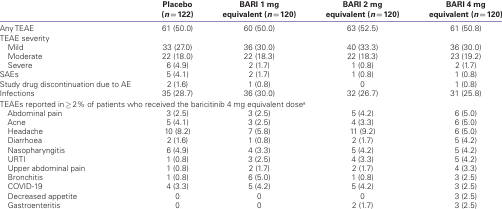

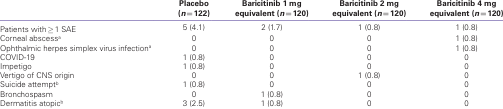

In [12]:
for file in os.listdir(cropped_table_directory):
    imageName = os.path.join(cropped_table_directory, file)
    display(Image(filename=imageName))